In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *

In [2]:
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.stats.api as sms

from src.utils import pmf_utils

In [3]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

filtered_data = pd.read_csv(Path(processed_dir, "processed_data_accu_60_filtered.csv"), index_col=None)
processed_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index_col=None)

# # exclude the following subjects where categorization score is more than 3
# reject_subs = processed_metadata.loc[processed_metadata["categorization_score"] > 3]['subject_id']
# processed_metadata = processed_metadata.loc[~processed_metadata["subject_id"].isin(reject_subs)]


In [4]:
processed_metadata['subject_id'].unique(), processed_metadata['subject_id'].unique().shape

(array(['P1', 'P4', 'P6', 'P7', 'P9', 'P11', 'P12', 'P13', 'P17', 'P18',
        'P19', 'P20', 'P22', 'P23', 'P24', 'CG', 'COH', 'MBY', 'DP', 'FUR',
        'LBR', 'MAR', 'SMI', 'PAM', 'RW', 'BBK', 'BER', 'DCAM', 'ALE',
        'DMO', 'RBA'], dtype=object),
 (31,))

In [5]:
# group by experiment_site
# processed_metadata.groupby('experiment_site')['subject_id'].unique()
# get subject_id for experiment_site = 'UCLA'
processed_metadata.loc[processed_metadata['experiment_site'] == 'UCLA']['subject_id'].unique()

array(['CG', 'COH', 'MBY', 'DP', 'FUR', 'LBR', 'MAR', 'SMI', 'PAM', 'RW',
       'BBK', 'BER', 'DCAM', 'ALE', 'DMO'], dtype=object)

In [6]:
filtered_data['subject_id'].unique()

array(['ALE', 'BBK', 'BER', 'CG', 'COH', 'DCAM', 'DMO', 'DP', 'FUR',
       'LBR', 'MAR', 'MBY', 'P1', 'P11', 'P12', 'P13', 'P17', 'P18',
       'P19', 'P20', 'P22', 'P23', 'P24', 'P4', 'P6', 'P7', 'P9', 'PAM',
       'RBA', 'RW', 'SMI'], dtype=object)

In [7]:
# Getting indices of on and off treatment from same subject in processed metadata
subject_treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])
treatment_idx = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(processed_metadata['subject_id'].unique()):
    sub_df = processed_metadata.loc[processed_metadata['subject_id'] == sub]
    subject_treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    # print(f"Subject {sub} with {sub_df['subject_id'].values}")
    print(f"Subject {sub} has {sub_df['categorization_score'].values} categorization_score")
    if np.sum(np.isnan(sub_df['categorization_score'])) == 0:
        # put off treatment first column and on treatment second column one row at a time
        treatment_idx.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

    # break

Subject P1 has [0.1958042  0.43636364] categorization_score
Subject P4 has [0.8        0.36923077] categorization_score
Subject P6 has [1.03896104 0.91428571] categorization_score
Subject P7 has [1.93939394 0.8       ] categorization_score
Subject P9 has [0.76190476 0.58181818] categorization_score
Subject P11 has [0.         1.33333333] categorization_score
Subject P12 has [1.12       3.55555556] categorization_score
Subject P13 has [0.43636364 0.56      ] categorization_score
Subject P17 has [1.00699301 0.31111111] categorization_score
Subject P18 has [0.16       1.09090909] categorization_score
Subject P19 has [3.73333333 1.11363636] categorization_score
Subject P20 has [0.         0.35109718] categorization_score
Subject P22 has [0.0969697 0.       ] categorization_score
Subject P23 has [0.45714286 0.15311005] categorization_score
Subject P24 has [0.93506494 2.66666667] categorization_score
Subject CG has [nan nan] categorization_score
Subject COH has [nan nan] categorization_score

In [8]:
treatment_idx

,subject,off,on
0,P1,0,1
1,P4,2,3
2,P6,4,5
3,P7,6,7
4,P9,9,8
5,P11,11,10
6,P12,13,12
7,P13,14,15
8,P17,16,17
9,P18,19,18


In [9]:
original_all_subjects = ['CG', 'COH', 'MBY', 'DP', 'FUR', 'LBR', 'MAR', 'SMI', 'RW', 'SGA']
original_trem_subjects = ['DP', 'FUR', 'LBR', 'MAR', 'SMI']
original_brady_subjects = ['CG', 'COH', 'MBY', 'RW', 'SGA']

new_trem_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'tremor_dominant']['subject_id'].unique()
new_brady_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'bradykinesia_dominant']['subject_id'].unique()
new_intermediate_subjects = processed_metadata.loc[processed_metadata['categorization'] == 'intermediate']['subject_id'].unique()
print(f"New tremor_subjects: {len(new_trem_subjects)} \t {new_trem_subjects}")
print(f"New brady_subjects: {len(new_brady_subjects)} \t{new_brady_subjects}")
print(f"New intermediate_subjects: {len(new_intermediate_subjects)} \t{new_intermediate_subjects}")

new_all_subjects = subject_treatment_idx['subject'].unique()
new_subtype_subjects = treatment_idx['subject'].unique()
# print(f"New all_subjects: {new_all_subjects}")
# print(f"New subtype_subjects: {new_subtype_subjects}")

New tremor_subjects: 7 	 ['P6' 'P7' 'P11' 'P12' 'P17' 'P18' 'P19']
New brady_subjects: 7 	['P1' 'P4' 'P9' 'P13' 'P20' 'P22' 'P23']
New intermediate_subjects: 1 	['P24']


### Psychometric Function plots

In [10]:

def add_inset_plot(ax, bias_1, bias_2, bias_1_err, bias_2_err):
	ax.bar(['Equal', 'Positive'], [bias_1, bias_2], color=['gray', 'black'], edgecolor='k')
	ax.errorbar(['Equal', 'Positive'], [bias_1, bias_2], yerr=[bias_1_err, bias_2_err], fmt='.', color='grey', markeredgecolor='k', capsize=5)
	ax.set_title('Bias', fontsize=15)
	ax.tick_params(axis='both', labelsize=12)
	ax.set_ylim(-0.2, 0.2)
	for spine in ['top', 'right']:
		ax.spines[spine].set_visible(False)
	for spine in ['bottom', 'left']:
		ax.spines[spine].set_visible(True)
		ax.spines[spine].set_linewidth(1)
	ax.axhline(0, color='k', lw=1)
	ax.grid(False)

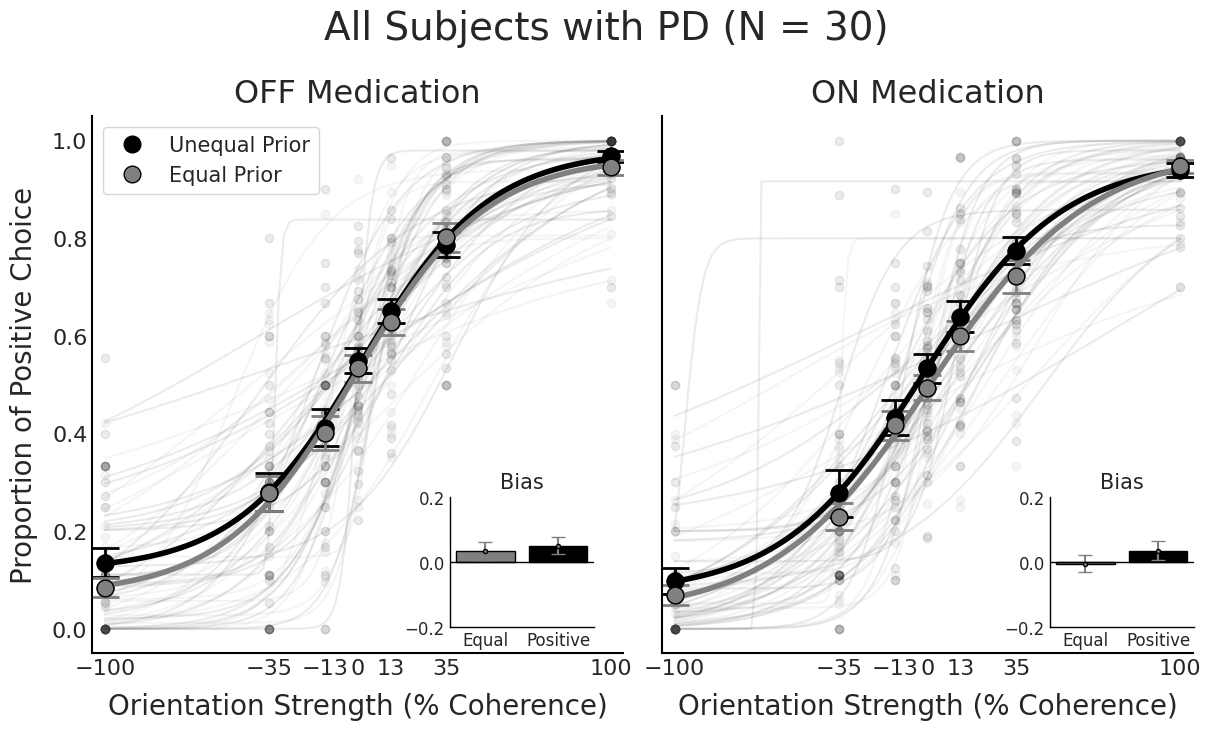

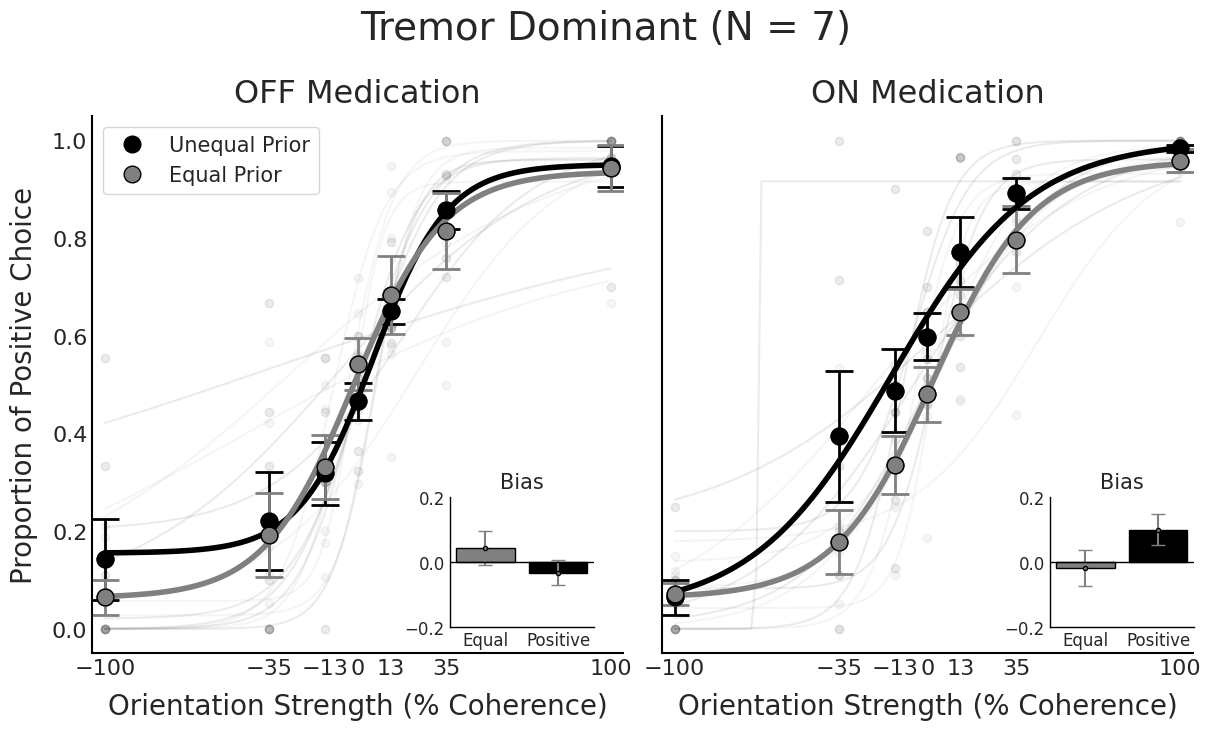

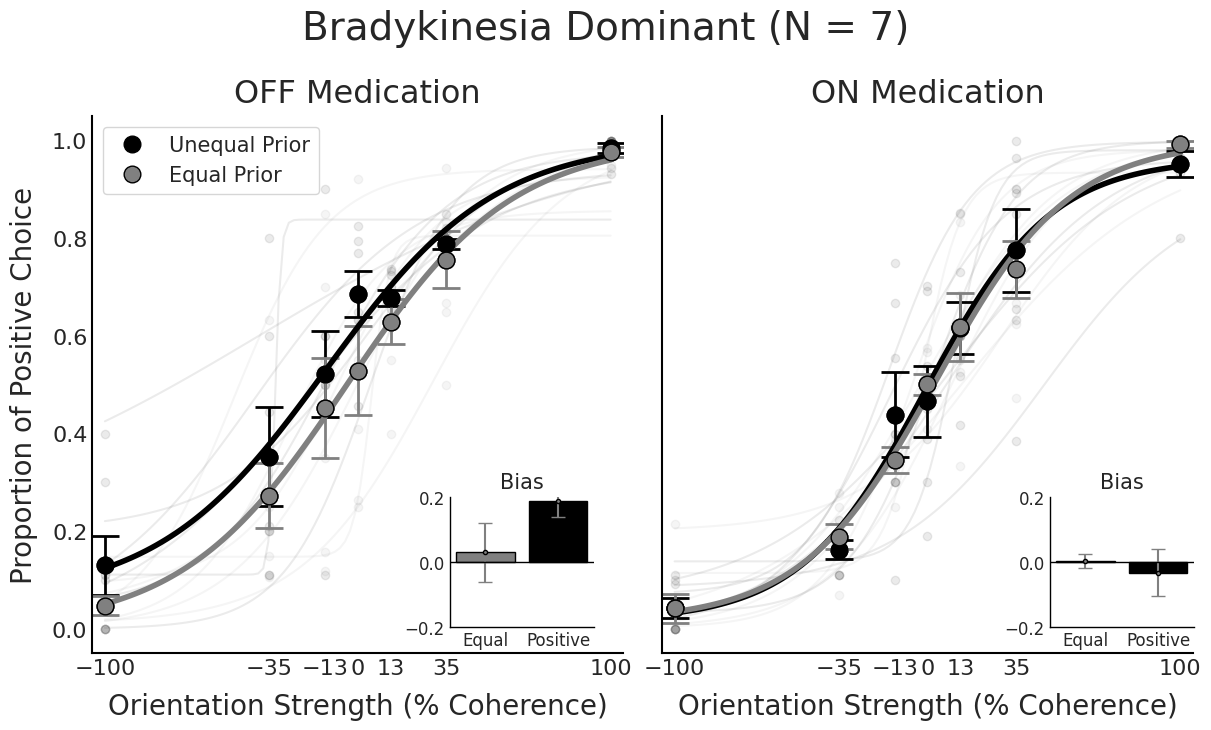

In [11]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

for category in ['all', 'tremor_dominant', 'bradykinesia_dominant']:

	if category == 'all':
		subjects = np.concatenate([new_brady_subjects, new_trem_subjects, new_intermediate_subjects, processed_metadata.loc[processed_metadata['experiment_site'] == 'UCLA']['subject_id'].unique()])
		subtitle = 'All Subjects with PD'
	elif category == 'tremor_dominant':
		subjects = new_trem_subjects
		subtitle = 'Tremor Dominant'
	elif category == 'bradykinesia_dominant':
		subjects = new_brady_subjects
		subtitle = 'Bradykinesia Dominant'

	fig, ax = plt.subplots(1, 2, figsize=(12, 6.5))

	subject_alpha = 0.08
	positive_color = 'black'# 'C5'
	equal_color = 'gray'
	error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

	sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
	sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
	sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
	sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []

	for i, subject in enumerate(subjects):
		subject_data = filtered_data[filtered_data['subject_id'] == subject]
		subject_data = subject_data.sort_values('medication')

		for idx, med in enumerate(subject_data['medication'].unique()):
			med_data = subject_data[subject_data['medication'] == med]
			pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 1])
			eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat  = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 0])

			if med == 'off':
				ax_idx = 0
				sub_off_pos_coh.append(pos_coh)
				sub_off_pos_psych.append(pos_psych)
				sub_off_pos_model.append(pos_model)
				sub_off_pos_x_hat.append(pos_x_hat)
				sub_off_pos_y_hat.append(pos_y_hat)
				sub_off_eq_coh.append(eq_coh)
				sub_off_eq_psych.append(eq_psych)
				sub_off_eq_model.append(eq_model)
				sub_off_eq_x_hat.append(eq_x_hat)
				sub_off_eq_y_hat.append(eq_y_hat)
			elif med == 'on':
				ax_idx = 1
				sub_on_pos_coh.append(pos_coh)
				sub_on_pos_psych.append(pos_psych)
				sub_on_pos_model.append(pos_model)
				sub_on_pos_x_hat.append(pos_x_hat)
				sub_on_pos_y_hat.append(pos_y_hat)
				sub_on_eq_coh.append(eq_coh)
				sub_on_eq_psych.append(eq_psych)
				sub_on_eq_model.append(eq_model)
				sub_on_eq_x_hat.append(eq_x_hat)
				sub_on_eq_y_hat.append(eq_y_hat)

			ax[ax_idx].plot(pos_coh, pos_psych, color=positive_color, marker='o', ls='', alpha=subject_alpha)
			ax[ax_idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
			ax[ax_idx].plot(eq_coh, eq_psych, color=equal_color, marker='o', ls='', alpha=subject_alpha)
			ax[ax_idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)


	ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
	ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
	ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), yerr=stats.sem(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), yerr=stats.sem(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	pos_model = pmf_utils.fit_psychometric_function(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), trial_counts=None, model_type="logit_4")
	eq_model = pmf_utils.fit_psychometric_function(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), trial_counts=None, model_type="logit_4")
	ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_off_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
	ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_off_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)


	ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
	ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
	ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), yerr=stats.sem(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), yerr=stats.sem(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	pos_model = pmf_utils.fit_psychometric_function(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), trial_counts=None, model_type="logit_4")
	eq_model = pmf_utils.fit_psychometric_function(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), trial_counts=None, model_type="logit_4")
	ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_on_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
	ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_on_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)


	ax[0].set_title(f"OFF Medication", fontsize=23, pad=10)
	ax[1].set_title(f"ON Medication", fontsize=23, pad=10)

	ax[0].legend(fontsize=15)


	ax[0].set_xlabel('Orientation Strength (% Coherence)', fontsize=20, labelpad=10)
	ax[0].set_ylabel('Proportion of Positive Choice', fontsize=20, labelpad=10)
	ax[0].set_xlim(-105, 105)
	ax[0].set_ylim(-0.05, 1.05)
	ax[0].set_xticks([-100, -35, -13, 0, 13, 35, 100])
	ax[0].tick_params(axis='both', labelsize=16)
	ax[0].spines['top'].set_visible(False)
	ax[0].spines['right'].set_visible(False)
	ax[0].grid(False)
	for spine in ['bottom', 'left']:
		ax[0].spines[spine].set_visible(True)
		ax[0].spines[spine].set_linewidth(1.5)  # Make them more visible
		ax[0].spines[spine].set_color('black')

	ax[1].set_xlabel('Orientation Strength (% Coherence)', fontsize=20, labelpad=10)
	# ax[1].set_ylabel('Proportion of Positive Choice', fontsize=20, labelpad=10)
	ax[1].set_xlim(-105, 105)
	ax[1].set_ylim(-0.05, 1.05)
	ax[1].set_xticks([-100, -35, -13, 0, 13, 35, 100])
	# remove y ticks
	ax[1].set_yticks([])
	ax[1].tick_params(axis='both', labelsize=16)
	ax[1].spines['top'].set_visible(False)
	ax[1].spines['right'].set_visible(False)
	ax[1].spines['left'].set_visible(False)
	ax[1].grid(False)
	for spine in ['bottom', 'left']:
		ax[1].spines[spine].set_visible(True)
		ax[1].spines[spine].set_linewidth(1.5)  # Make them more visible
		ax[1].spines[spine].set_color('black')


	fig.suptitle(f"{subtitle} (N = {len(subjects)})", fontsize=28, y=1.1)
	# add text to the top left corner

	# Example slopes (replace with your actual metric)
	off_pos_bias = np.mean(sub_off_pos_psych, axis=0)[3] - 0.5
	off_pos_bias_err = stats.sem(sub_off_pos_psych, axis=0)[3]
	off_eq_bias  = np.mean(sub_off_eq_psych, axis=0)[3] - 0.5
	off_eq_bias_err  = stats.sem(sub_off_eq_psych, axis=0)[3]
	on_pos_bias = np.mean(sub_on_pos_psych, axis=0)[3] - 0.5
	on_pos_bias_err = stats.sem(sub_on_pos_psych, axis=0)[3]
	on_eq_bias  = np.mean(sub_on_eq_psych, axis=0)[3] - 0.5
	on_eq_bias_err  = stats.sem(sub_on_eq_psych, axis=0)[3]

	inset_ax = fig.add_axes([0.37, 0.15, 0.12, 0.2])  # [left, bottom, width, height]
	add_inset_plot(inset_ax, off_eq_bias, off_pos_bias, off_eq_bias_err, off_pos_bias_err)
	inset_ax = fig.add_axes([0.87, 0.15, 0.12, 0.2])  # [left, bottom, width, height]
	add_inset_plot(inset_ax, on_eq_bias, on_pos_bias, on_eq_bias_err, on_pos_bias_err)

	fig.tight_layout()
	plt.show()



Wilcoxon test results:
OFF Positive bias vs 0: p = 1.0000
OFF Equal bias vs 0   : p = 1.0000
ON Positive bias vs 0 : p = 1.0000
ON Equal bias vs 0    : p = 1.0000
OFF Pos vs Eq         : p = 1.0000
ON Pos vs Eq          : p = 1.0000
Wilcoxon test results:
OFF Positive bias vs 0: p = 1.0000
OFF Equal bias vs 0   : p = 1.0000
ON Positive bias vs 0 : p = 1.0000
ON Equal bias vs 0    : p = 1.0000
OFF Pos vs Eq         : p = 1.0000
ON Pos vs Eq          : p = 1.0000
Wilcoxon test results:
OFF Positive bias vs 0: p = 1.0000
OFF Equal bias vs 0   : p = 1.0000
ON Positive bias vs 0 : p = 1.0000
ON Equal bias vs 0    : p = 1.0000
OFF Pos vs Eq         : p = 1.0000
ON Pos vs Eq          : p = 1.0000


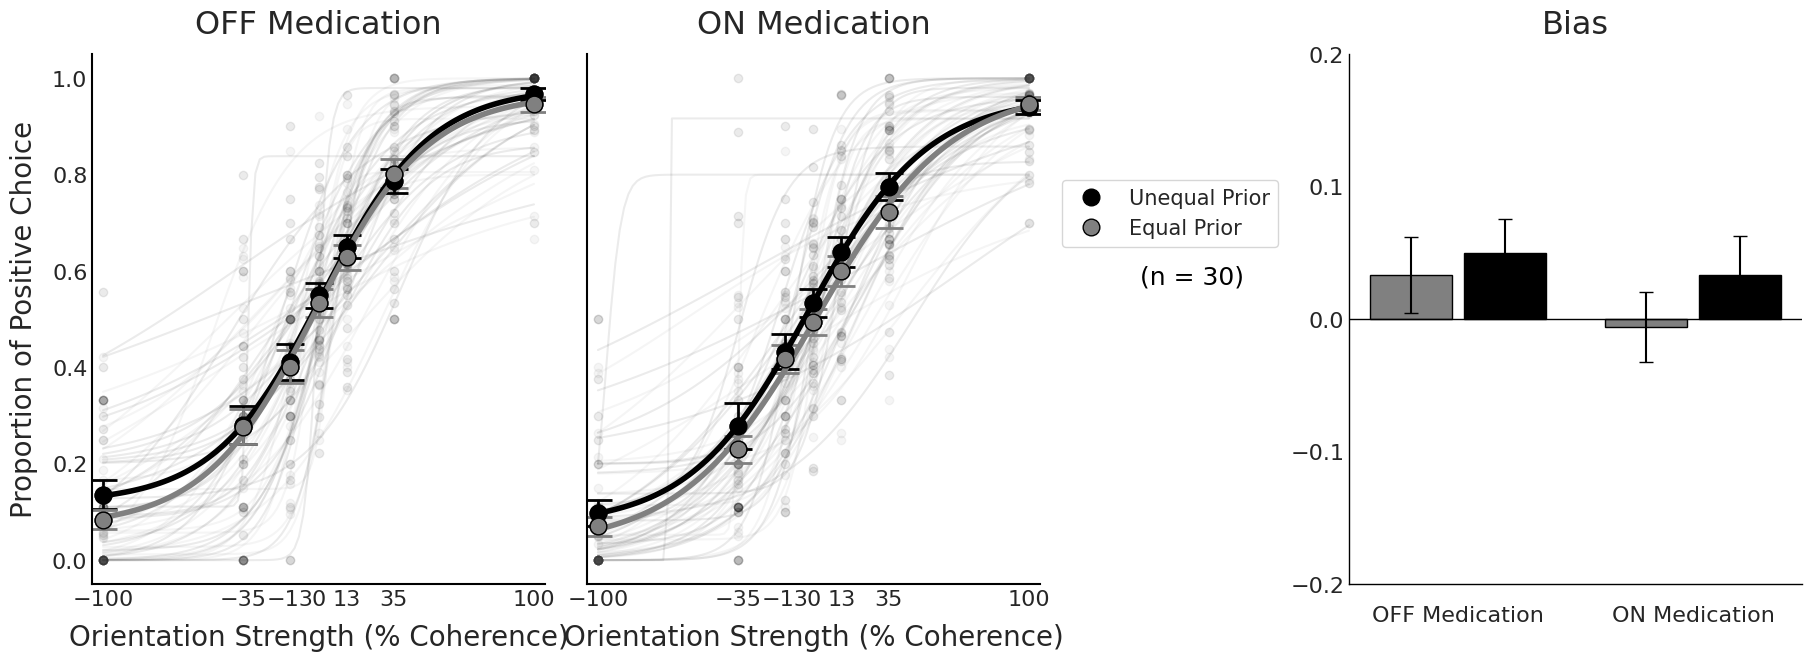

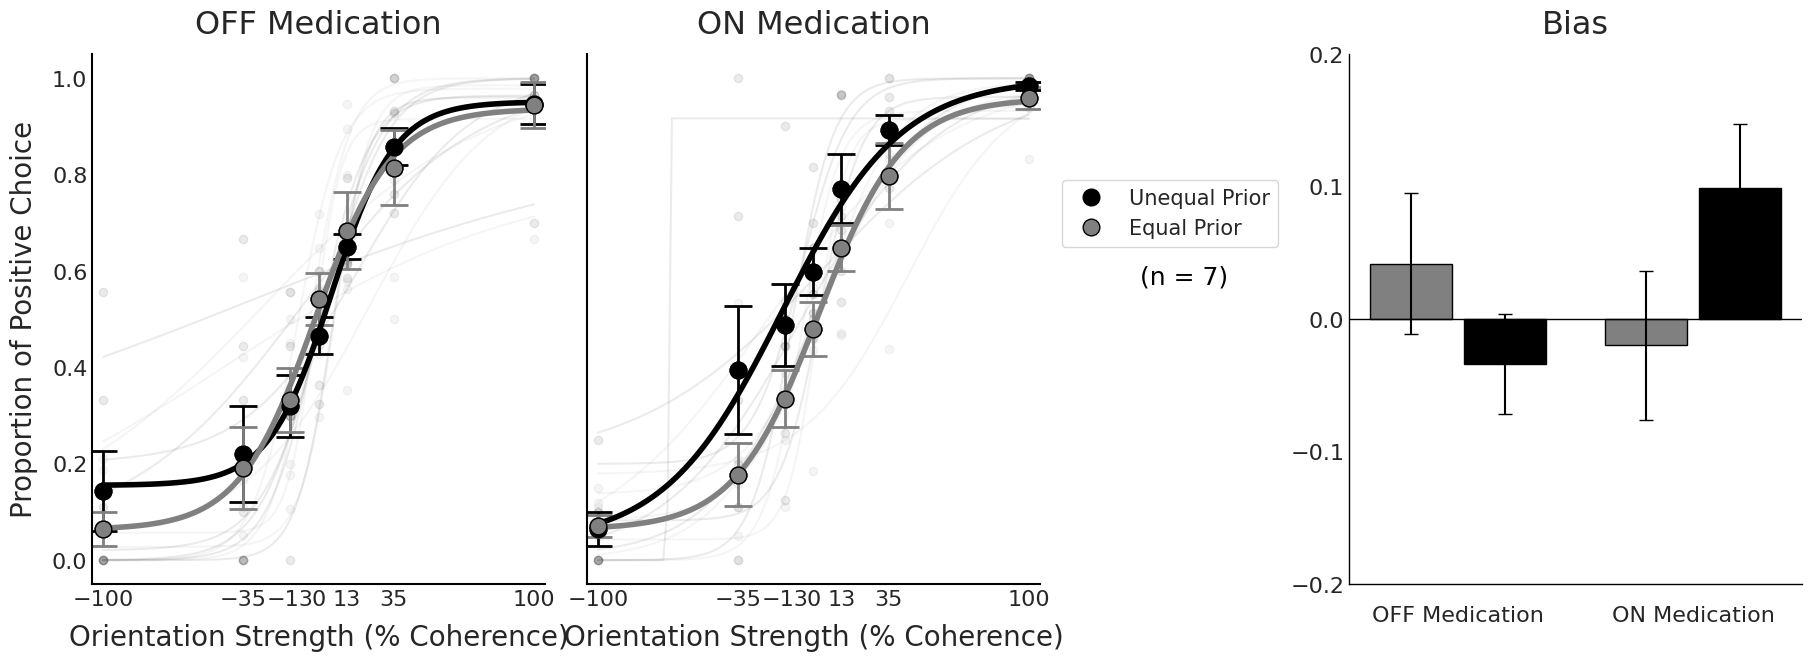

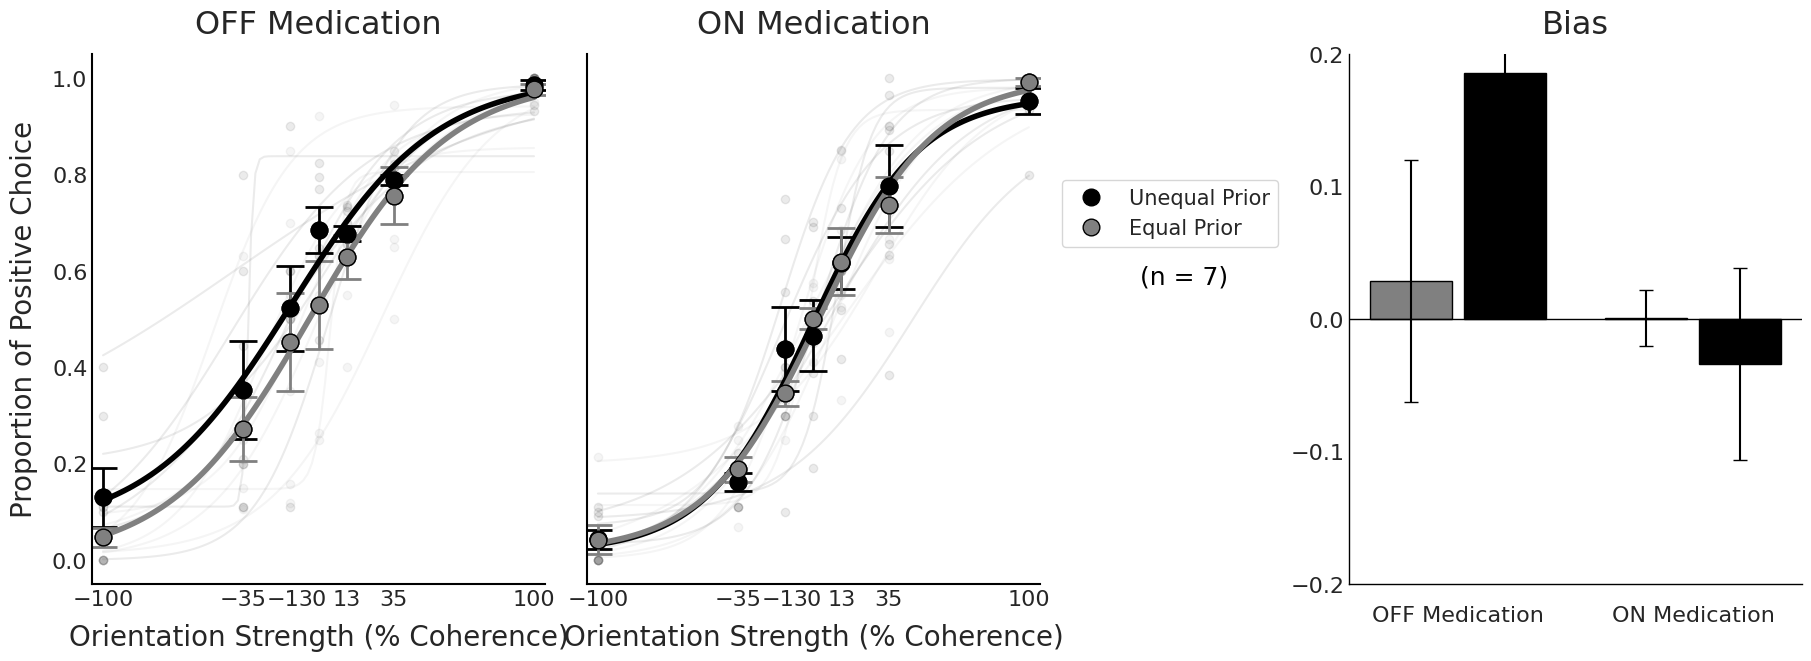

In [12]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

for category in ['all', 'tremor_dominant', 'bradykinesia_dominant']:

	if category == 'all':
		subjects = np.concatenate([new_brady_subjects, new_trem_subjects, new_intermediate_subjects, processed_metadata.loc[processed_metadata['experiment_site'] == 'UCLA']['subject_id'].unique()])
		subtitle = 'All Subjects with PD'
	elif category == 'tremor_dominant':
		subjects = new_trem_subjects
		subtitle = 'Tremor Dominant'
	elif category == 'bradykinesia_dominant':
		subjects = new_brady_subjects
		subtitle = 'Bradykinesia Dominant'

	fig, ax = plt.subplots(1, 3, figsize=(18, 6.5))

	subject_alpha = 0.08
	positive_color = 'black'# 'C5'
	equal_color = 'gray'
	error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

	sub_off_pos_coh, sub_off_pos_psych, sub_off_pos_model, sub_off_pos_x_hat, sub_off_pos_y_hat = [], [], [], [], []
	sub_off_eq_coh, sub_off_eq_psych, sub_off_eq_model, sub_off_eq_x_hat, sub_off_eq_y_hat = [], [], [], [], []
	sub_on_pos_coh, sub_on_pos_psych, sub_on_pos_model, sub_on_pos_x_hat, sub_on_pos_y_hat = [], [], [], [], []
	sub_on_eq_coh, sub_on_eq_psych, sub_on_eq_model, sub_on_eq_x_hat, sub_on_eq_y_hat = [], [], [], [], []

	for i, subject in enumerate(subjects):
		subject_data = filtered_data[filtered_data['subject_id'] == subject]
		subject_data = subject_data.sort_values('medication')

		for idx, med in enumerate(subject_data['medication'].unique()):
			med_data = subject_data[subject_data['medication'] == med]
			pos_coh, pos_psych, pos_model, pos_x_hat, pos_y_hat = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 1])
			eq_coh, eq_psych, eq_model, eq_x_hat, eq_y_hat  = pmf_utils.get_psychometric_data(med_data[med_data['color'] == 0])

			if med == 'off':
				ax_idx = 0
				sub_off_pos_coh.append(pos_coh)
				sub_off_pos_psych.append(pos_psych)
				sub_off_pos_model.append(pos_model)
				sub_off_pos_x_hat.append(pos_x_hat)
				sub_off_pos_y_hat.append(pos_y_hat)
				sub_off_eq_coh.append(eq_coh)
				sub_off_eq_psych.append(eq_psych)
				sub_off_eq_model.append(eq_model)
				sub_off_eq_x_hat.append(eq_x_hat)
				sub_off_eq_y_hat.append(eq_y_hat)
			elif med == 'on':
				ax_idx = 1
				sub_on_pos_coh.append(pos_coh)
				sub_on_pos_psych.append(pos_psych)
				sub_on_pos_model.append(pos_model)
				sub_on_pos_x_hat.append(pos_x_hat)
				sub_on_pos_y_hat.append(pos_y_hat)
				sub_on_eq_coh.append(eq_coh)
				sub_on_eq_psych.append(eq_psych)
				sub_on_eq_model.append(eq_model)
				sub_on_eq_x_hat.append(eq_x_hat)
				sub_on_eq_y_hat.append(eq_y_hat)

			ax[ax_idx].plot(pos_coh, pos_psych, color=positive_color, marker='o', ls='', alpha=subject_alpha)
			ax[ax_idx].plot(pos_x_hat, pos_y_hat, color=positive_color, ls='-', alpha=subject_alpha)
			ax[ax_idx].plot(eq_coh, eq_psych, color=equal_color, marker='o', ls='', alpha=subject_alpha)
			ax[ax_idx].plot(eq_x_hat, eq_y_hat, color=equal_color, ls='-', alpha=subject_alpha)


	ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
	ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
	ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), yerr=stats.sem(sub_off_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), yerr=stats.sem(sub_off_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	pos_model = pmf_utils.fit_psychometric_function(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_psych, axis=0), trial_counts=None, model_type="logit_4")
	eq_model = pmf_utils.fit_psychometric_function(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_psych, axis=0), trial_counts=None, model_type="logit_4")
	ax[0].plot(np.mean(sub_off_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_off_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
	ax[0].plot(np.mean(sub_off_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_off_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)


	ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
	ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
	ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), yerr=stats.sem(sub_on_pos_psych, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), yerr=stats.sem(sub_on_eq_psych, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
	pos_model = pmf_utils.fit_psychometric_function(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_psych, axis=0), trial_counts=None, model_type="logit_4")
	eq_model = pmf_utils.fit_psychometric_function(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_psych, axis=0), trial_counts=None, model_type="logit_4")
	ax[1].plot(np.mean(sub_on_pos_x_hat, axis=0), pos_model.predict(np.mean(sub_on_pos_x_hat, axis=0)), color=positive_color, ls='-', lw=4, alpha=1)
	ax[1].plot(np.mean(sub_on_eq_x_hat, axis=0), eq_model.predict(np.mean(sub_on_eq_x_hat, axis=0)), color=equal_color, ls='-', lw=4, alpha=1)


	off_pos_bias = np.mean(sub_off_pos_psych, axis=0)[3] - 0.5
	off_pos_bias_err = stats.sem(sub_off_pos_psych, axis=0)[3]
	off_eq_bias  = np.mean(sub_off_eq_psych, axis=0)[3] - 0.5
	off_eq_bias_err  = stats.sem(sub_off_eq_psych, axis=0)[3]
	on_pos_bias = np.mean(sub_on_pos_psych, axis=0)[3] - 0.5
	on_pos_bias_err = stats.sem(sub_on_pos_psych, axis=0)[3]
	on_eq_bias  = np.mean(sub_on_eq_psych, axis=0)[3] - 0.5
	on_eq_bias_err  = stats.sem(sub_on_eq_psych, axis=0)[3]

	labels = ['OFF Medication', 'ON Medication']
	conditions = ['OFF', 'ON']

	bias_means = [[off_eq_bias, on_eq_bias],  # Equal: OFF, ON
				[off_pos_bias, on_pos_bias]]  # Positive: OFF, ON

	bias_errors = [[off_eq_bias_err, on_eq_bias_err],
				[off_pos_bias_err, on_pos_bias_err]]

	x = np.arange(len(labels))  # label locations
	width = 0.35  # width of each bar
	spacing_within_group = 0.025

	# Plotting
	ax[2].bar(x - width/2 - spacing_within_group, bias_means[0], width, yerr=bias_errors[0], color='gray', edgecolor='k', capsize=5)
	ax[2].bar(x + width/2 + spacing_within_group, bias_means[1], width, yerr=bias_errors[1], color='black', edgecolor='k', capsize=5)


	ax[0].set_xlabel('Orientation Strength (% Coherence)', fontsize=20, labelpad=10)
	ax[0].set_ylabel('Proportion of Positive Choice', fontsize=20, labelpad=10)
	ax[0].set_xlim(-105, 105)
	ax[0].set_ylim(-0.05, 1.05)
	ax[0].set_xticks([-100, -35, -13, 0, 13, 35, 100])
	ax[0].tick_params(axis='both', labelsize=16)
	ax[0].spines['top'].set_visible(False)
	ax[0].spines['right'].set_visible(False)
	ax[0].grid(False)
	for spine in ['bottom', 'left']:
		ax[0].spines[spine].set_visible(True)
		ax[0].spines[spine].set_linewidth(1.5)  # Make them more visible
		ax[0].spines[spine].set_color('black')


	ax[1].set_xlabel('Orientation Strength (% Coherence)', fontsize=20, labelpad=10)
	# ax[1].set_ylabel('Proportion of Positive Choice', fontsize=20, labelpad=10)
	ax[1].set_xlim(-105, 105)
	ax[1].set_ylim(-0.05, 1.05)
	ax[1].set_xticks([-100, -35, -13, 0, 13, 35, 100])
	# remove y ticks
	ax[1].set_yticks([])
	ax[1].tick_params(axis='both', labelsize=16)
	ax[1].spines['top'].set_visible(False)
	ax[1].spines['right'].set_visible(False)
	ax[1].spines['left'].set_visible(False)
	ax[1].grid(False)
	for spine in ['bottom', 'left']:
		ax[1].spines[spine].set_visible(True)
		ax[1].spines[spine].set_linewidth(1.5)  # Make them more visible
		ax[1].spines[spine].set_color('black')
	# Aesthetics
	ax[2].set_xticks(x)
	ax[2].set_xticklabels(labels, fontsize=20)

	ax[2].tick_params(axis='x', labelsize=20, pad=15)  # 'pad' controls the spacing)
	# yticks every 0.1
	ax[2].set_yticks(np.arange(-0.2, 0.3, 0.1))
	ax[2].tick_params(axis='both', labelsize=16)
	ax[2].set_ylim(-0.2, 0.2)
	ax[2].axhline(0, color='k', lw=1)
	for spine in ['top', 'right']:
		ax[2].spines[spine].set_visible(False)
	for spine in ['bottom', 'left']:
		ax[2].spines[spine].set_visible(True)
		ax[2].spines[spine].set_linewidth(1)
	# ax[2].legend(fontsize=12)
	ax[2].grid(False)


	ax[0].set_title(f"OFF Medication", fontsize=23, pad=15)
	ax[1].set_title(f"ON Medication", fontsize=23, pad=15)
	ax[2].set_title(f"Bias", fontsize=23, pad=15)

	fig.tight_layout()
	ax[1].legend(
		fontsize=15,
		loc='center left',
		bbox_to_anchor=(1.05, 0.7),  # Pushes legend to the right of ax[0]
		borderaxespad=0
	)
	fig.text(.63, 0.6, f"(n = {len(subjects)})", fontsize=18, ha='left', va='top', color='black')



	from scipy.stats import wilcoxon

	# 1. Test bias ≠ 0 for each condition
	p_off_pos_vs_zero = wilcoxon(off_pos_bias).pvalue
	p_off_eq_vs_zero  = wilcoxon(off_eq_bias).pvalue
	p_on_pos_vs_zero  = wilcoxon(on_pos_bias).pvalue
	p_on_eq_vs_zero   = wilcoxon(on_eq_bias).pvalue

	# 2. Test pos vs eq within OFF and ON
	p_off_pos_vs_eq = wilcoxon(off_pos_bias, off_eq_bias).pvalue
	p_on_pos_vs_eq  = wilcoxon(on_pos_bias, on_eq_bias).pvalue

	# Print results
	print("Wilcoxon test results:")
	print(f"OFF Positive bias vs 0: p = {p_off_pos_vs_zero:.4f}")
	print(f"OFF Equal bias vs 0   : p = {p_off_eq_vs_zero:.4f}")
	print(f"ON Positive bias vs 0 : p = {p_on_pos_vs_zero:.4f}")
	print(f"ON Equal bias vs 0    : p = {p_on_eq_vs_zero:.4f}")
	print(f"OFF Pos vs Eq         : p = {p_off_pos_vs_eq:.4f}")
	print(f"ON Pos vs Eq          : p = {p_on_pos_vs_eq:.4f}")



In [13]:
temp_data = filtered_data.copy()
# rename response_time to reaction_time
temp_data = temp_data.rename(columns={'reaction_time':'response_time'})

In [14]:
subject_treatment_idx

,subject,off,on
0,P1,0,1
1,P4,2,3
2,P6,4,5
3,P7,6,7
4,P9,9,8
5,P11,11,10
6,P12,13,12
7,P13,14,15
8,P17,16,17
9,P18,19,18


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (15,) + inhomogeneous part.

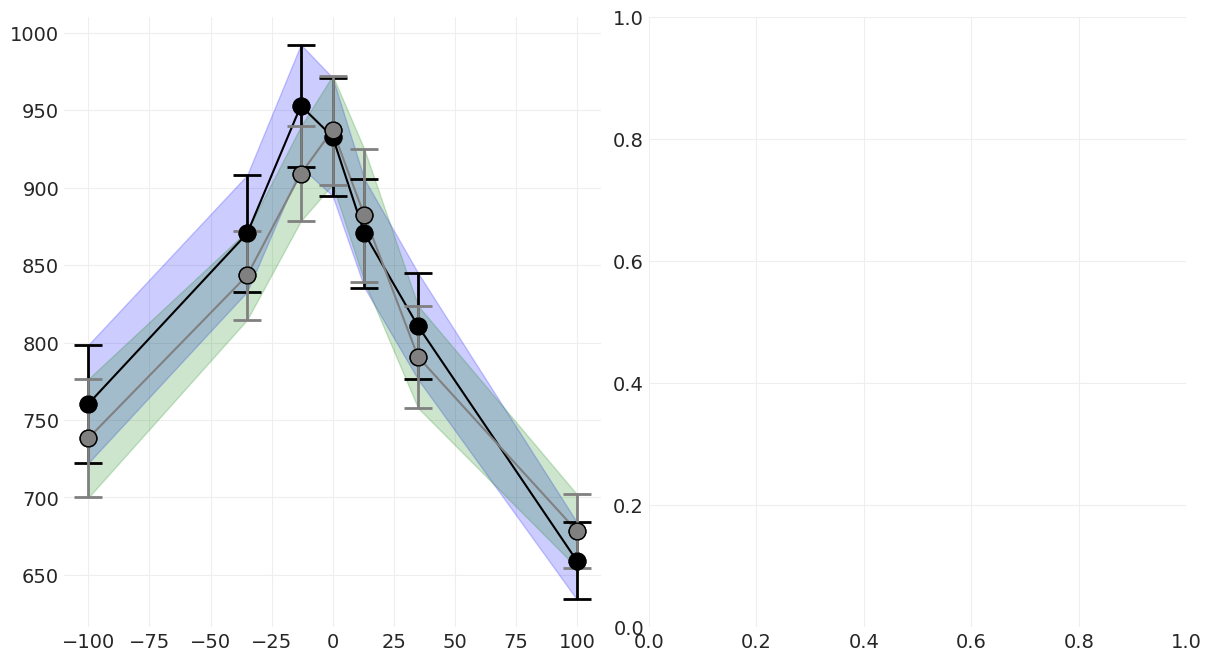

In [15]:
# for each subject, plot psychometric function for on and off medication sessions for positive and negative colors

for category in ['all', 'tremor_dominant', 'bradykinesia_dominant']:

    if category == 'all':
        subjects = np.concatenate([new_brady_subjects, new_trem_subjects, new_intermediate_subjects])#, original_all_subjects])
        subtitle = 'PD Patients'
    elif category == 'tremor_dominant':
        subjects = new_trem_subjects
        subtitle = 'Tremor Dominant'
    elif category == 'bradykinesia_dominant':
        subjects = new_brady_subjects
        subtitle = 'Bradykinesia Dominant'

    fig, ax = plt.subplots(1, 2, figsize=(12, 6.5))
    subject_alpha = 0.08
    positive_color = 'black'# 'C5'
    equal_color = 'gray'
    error_plot_style = {'elinewidth': 2, 'capsize': 10, 'capthick': 2}

    sub_off_pos_coh, sub_off_pos_chrono = [], []
    sub_off_eq_coh, sub_off_eq_chrono = [], []
    sub_on_pos_coh, sub_on_pos_chrono = [], []
    sub_on_eq_coh, sub_on_eq_chrono = [], []

    for i, subject in enumerate(subjects):
        subject_data = temp_data[temp_data['subject_id'] == subject]
        subject_data = subject_data.sort_values('medication')

        for idx, med in enumerate(subject_data['medication'].unique()):
            med_data = subject_data[subject_data['medication'] == med]
            pos_coh, _, pos_chrono, _ = pmf_utils.get_chronometric_data(med_data[med_data['color'] == 1])
            eq_coh, _, eq_chrono, _ = pmf_utils.get_chronometric_data(med_data[med_data['color'] == 0])

            if med == 'off':
                ax_idx = 0
                sub_off_pos_coh.append(pos_coh)
                sub_off_pos_chrono.append(pos_chrono)
                sub_off_eq_coh.append(eq_coh)
                sub_off_eq_chrono.append(eq_chrono)
            elif med == 'on':
                ax_idx = 1
                sub_on_pos_coh.append(pos_coh)
                sub_on_pos_chrono.append(pos_chrono)
                sub_on_eq_coh.append(eq_coh)
                sub_on_eq_chrono.append(eq_chrono)


    ax[0].plot(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0), color=positive_color, ls='-', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[0].plot(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0), color=equal_color, ls='-', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[0].errorbar(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0), yerr=stats.sem(sub_off_pos_chrono, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[0].errorbar(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0), yerr=stats.sem(sub_off_eq_chrono, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    # fill between the error bars
    ax[0].fill_between(np.mean(sub_off_pos_coh, axis=0), np.mean(sub_off_pos_chrono, axis=0) - stats.sem(sub_off_pos_chrono, axis=0), np.mean(sub_off_pos_chrono, axis=0) + stats.sem(sub_off_pos_chrono, axis=0), color='blue', alpha=0.2, label='Unqual Prior SEM')
    ax[0].fill_between(np.mean(sub_off_eq_coh, axis=0), np.mean(sub_off_eq_chrono, axis=0) - stats.sem(sub_off_eq_chrono, axis=0), np.mean(sub_off_eq_chrono, axis=0) + stats.sem(sub_off_eq_chrono, axis=0), color='green', alpha=0.2, label='Equal Prior SEM')

    ax[1].plot(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0), color=positive_color, ls='-', marker='o', ms=12, mec='k', label='Unequal Prior', alpha=1)
    ax[1].plot(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0), color=equal_color, ls='-', marker='o', ms=12, mec='k', label='Equal Prior', alpha=1)
    ax[1].errorbar(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0), yerr=stats.sem(sub_on_pos_chrono, axis=0), color=positive_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    ax[1].errorbar(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0), yerr=stats.sem(sub_on_eq_chrono, axis=0), color=equal_color, ls='', marker='o', ms=12, mec='k', alpha=1, **error_plot_style)
    # fill between the error bars
    ax[1].fill_between(np.mean(sub_on_pos_coh, axis=0), np.mean(sub_on_pos_chrono, axis=0) - stats.sem(sub_on_pos_chrono, axis=0), np.mean(sub_on_pos_chrono, axis=0) + stats.sem(sub_on_pos_chrono, axis=0), color='blue', alpha=0.2)
    ax[1].fill_between(np.mean(sub_on_eq_coh, axis=0), np.mean(sub_on_eq_chrono, axis=0) - stats.sem(sub_on_eq_chrono, axis=0), np.mean(sub_on_eq_chrono, axis=0) + stats.sem(sub_on_eq_chrono, axis=0), color='green', alpha=0.2)


    ax[0].set_title(f"OFF medication", fontsize=23)
    ax[1].set_title(f"ON medication", fontsize=23)

    ax[0].legend(fontsize=15)

    for i in range(2):
        ax[i].set_xlabel('Orientation Strength (% Coherence)', fontsize=20)
        ax[i].set_ylabel('Reaction Time (in msec)', fontsize=20)
        ax[i].set_xlim(-105, 105)
        ax[i].set_ylim(400, 1200)
        ax[i].set_xticks([-100, -35, -13, 0, 13, 35, 100])
        ax[i].tick_params(axis='both', labelsize=16)
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].grid(False)

    fig.suptitle(f"{subtitle}", fontsize=28)

    # Add a text annotation with the number of subjects
    fig.text(0.84, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)
    # fig.text(0.35, 0.18, f"Number of subjects: {len(subjects)}", ha='center', fontsize=18)

    fig.tight_layout()
    plt.show()



### Categorization statistical analysis

In [ ]:
brady_treatment_idx = subject_treatment_idx[subject_treatment_idx['subject'].isin(new_brady_subjects)]
trem_treatment_idx = subject_treatment_idx[subject_treatment_idx['subject'].isin(new_trem_subjects)]
all_treatment_idx = subject_treatment_idx[subject_treatment_idx['subject'].isin(np.concatenate([new_brady_subjects, new_trem_subjects, processed_metadata.loc[processed_metadata['experiment_site'] == 'UCLA']['subject_id'].unique()]))]

In [ ]:
from scipy.stats import wilcoxon

# independent_variables = ['psych_alpha', 'psych_beta', 'psych_lapse', 'psych_guess', 'bias']
independent_variables = ['bias']

print("Wilcoxon signed-rank test")

for subtype in ['all_treatment_idx', 'bradykinesia_dominant', 'tremor_dominant']:

	print("---------------------------------------------------")
	if subtype == 'tremor_dominant':
		treatment_idx = trem_treatment_idx
		print("Tremor Dominant")
	elif subtype == 'bradykinesia_dominant':
		treatment_idx = brady_treatment_idx
		print("Bradykinesia Dominant")
	elif subtype == 'all_treatment_idx':
		treatment_idx = all_treatment_idx
		print("All Subjects")
	for independent_variable in independent_variables:
		# OFF medication
		off_positive_variables = processed_metadata.loc[treatment_idx['off']][f'positive_{independent_variable}']
		off_equal_variables = processed_metadata.loc[treatment_idx['off']][f'equal_{independent_variable}']
		# ON medication
		on_positive_variables = processed_metadata.loc[treatment_idx['on']][f'positive_{independent_variable}']
		on_equal_variables = processed_metadata.loc[treatment_idx['on']][f'equal_{independent_variable}']


		# Wilcoxon signed-rank test
		print(f" OFF medication Positive {independent_variable}: \t\t p-value: {stats.wilcoxon(off_positive_variables-0.5)[1]:.3f}")
		print(f" OFF medication Equal {independent_variable}: \t\t p-value: {stats.wilcoxon(off_equal_variables-0.5)[1]:.3f}")
		print(f" OFF medication Positive vs Equal {independent_variable}:\t p-value: {stats.wilcoxon(off_positive_variables, off_equal_variables)[1]:.3f}\n")
		print(f" ON medication Positive {independent_variable}: \t\t p-value: {stats.wilcoxon(on_positive_variables-0.5)[1]:.3f}")
		print(f" ON medication Equal {independent_variable}: \t\t p-value: {stats.wilcoxon(on_equal_variables-0.5)[1]:.3f}")
		print(f" ON medicationPositive vs Equal {independent_variable}: \t p-value: {stats.wilcoxon(on_positive_variables, on_equal_variables)[1]:.3f}")


In [ ]:
from scipy.stats import wilcoxon
from statsmodels.stats.power import TTestPower
import numpy as np

# Setup power analysis instance
power_analysis = TTestPower()

# Only one independent variable in your example
independent_variables = ['bias']

print("Wilcoxon signed-rank test with power estimation (T-test approximation)\n")

for subtype in ['all_treatment_idx', 'bradykinesia_dominant', 'tremor_dominant']:
    print("---------------------------------------------------")

    if subtype == 'tremor_dominant':
        treatment_idx = trem_treatment_idx
        print("Tremor Dominant")
    elif subtype == 'bradykinesia_dominant':
        treatment_idx = brady_treatment_idx
        print("Bradykinesia Dominant")
    elif subtype == 'all_treatment_idx':
        treatment_idx = all_treatment_idx
        print("All Subjects")

    for independent_variable in independent_variables:
        # Extract variables
        off_pos = processed_metadata.loc[treatment_idx['off']][f'positive_{independent_variable}']
        off_eq = processed_metadata.loc[treatment_idx['off']][f'equal_{independent_variable}']
        on_pos = processed_metadata.loc[treatment_idx['on']][f'positive_{independent_variable}']
        on_eq = processed_metadata.loc[treatment_idx['on']][f'equal_{independent_variable}']

        # Function to compute power
        def compute_power(data, mu0=0.5):
            effect_size = (data.mean() - mu0) / data.std(ddof=1)
            return power_analysis.power(effect_size=effect_size, nobs=len(data), alpha=0.05)

        # OFF
        p1 = wilcoxon(off_pos - 0.5).pvalue
        p2 = wilcoxon(off_eq - 0.5).pvalue
        p3 = wilcoxon(off_pos, off_eq).pvalue

        print(f" OFF Positive vs 0.5:      p = {p1:.3f}, power = {compute_power(off_pos):.3f}")
        print(f" OFF Equal vs 0.5:         p = {p2:.3f}, power = {compute_power(off_eq):.3f}")
        print(f" OFF Positive vs Equal:    p = {p3:.3f}, power = {compute_power(off_pos - off_eq):.3f}\n")

        # ON
        p4 = wilcoxon(on_pos - 0.5).pvalue
        p5 = wilcoxon(on_eq - 0.5).pvalue
        p6 = wilcoxon(on_pos, on_eq).pvalue

        print(f" ON Positive vs 0.5:       p = {p4:.3f}, power = {compute_power(on_pos):.3f}")
        print(f" ON Equal vs 0.5:          p = {p5:.3f}, power = {compute_power(on_eq):.3f}")
        print(f" ON Positive vs Equal:     p = {p6:.3f}, power = {compute_power(on_pos - on_eq):.3f}")


In [ ]:
from scipy.stats import wilcoxon
from statsmodels.stats.power import TTestPower
from statsmodels.stats.multitest import multipletests
import numpy as np

# Setup power analysis instance
power_analysis = TTestPower()

# Only one independent variable in your example
independent_variables = ['bias']

print("Wilcoxon signed-rank test with power estimation (T-test approximation + Bonferroni correction)\n")

for subtype in ['all_treatment_idx', 'bradykinesia_dominant', 'tremor_dominant']:
    print("---------------------------------------------------")

    if subtype == 'tremor_dominant':
        treatment_idx = trem_treatment_idx
        print("Tremor Dominant")
    elif subtype == 'bradykinesia_dominant':
        treatment_idx = brady_treatment_idx
        print("Bradykinesia Dominant")
    elif subtype == 'all_treatment_idx':
        treatment_idx = all_treatment_idx
        print("All Subjects")

    for independent_variable in independent_variables:
        # Extract variables
        off_pos = processed_metadata.loc[treatment_idx['off']][f'positive_{independent_variable}']
        off_eq = processed_metadata.loc[treatment_idx['off']][f'equal_{independent_variable}']
        on_pos = processed_metadata.loc[treatment_idx['on']][f'positive_{independent_variable}']
        on_eq = processed_metadata.loc[treatment_idx['on']][f'equal_{independent_variable}']

        # Function to compute power
        def compute_power(data, mu0=0.5):
            std = data.std(ddof=1)
            if std == 0:  # Avoid divide by zero
                return np.nan
            effect_size = (data.mean() - mu0) / std
            return power_analysis.power(effect_size=effect_size, nobs=len(data), alpha=0.05)

        # Run Wilcoxon tests (you can add or remove tests as needed)
        pvals = [
            wilcoxon(off_pos, off_eq).pvalue,      # OFF Positive vs Equal
            wilcoxon(on_pos, on_eq).pvalue        # ON Positive vs Equal
        ]

        # Bonferroni correction for multiple comparisons
        corrected_pvals = multipletests(pvals, method='bonferroni')[1]

        # Print results for each test with power calculations
        print(f" OFF Positive vs Equal:    p = {pvals[0]:.3f}, corrected p = {corrected_pvals[0]:.3f}, power = {compute_power(off_pos - off_eq):.3f}\n")
        print(f" ON Positive vs Equal:     p = {pvals[1]:.3f}, corrected p = {corrected_pvals[1]:.3f}, power = {compute_power(on_pos - on_eq):.3f}")
